# Deep Learning
## CNNs for image classification (Abnormality Detection in bone X-Ray)
---
>Nikolaos Mavroforos (nmavroforos@aueb.gr) <br>
>Panagiotis Ntenezos (p.ntenezos@aueb.gr)

In [1]:
import os
import random
import cv2
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)


from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.layers import Input, Activation,BatchNormalization,Flatten,Dropout,Dense
from tensorflow.keras.layers import Conv2D,SpatialDropout2D,AvgPool2D,MaxPool2D,GlobalAveragePooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy

from tensorflow.keras.applications import ResNet152V2, DenseNet201

# Functions

In [2]:
def load_data(path):
    dataset = [] 

    for body in os.listdir(path):
        body_part = body
        path_to_body_part = path+'/'+str(body)
        
        for patient in os.listdir(path_to_body_part):
            patient_id = patient
            path_to_patient = path_to_body_part +'/'+str(patient_id)
            
            for result in os.listdir(path_to_patient):
                if result.split('_')[-1]=='positive': 
                    label = 1 
                elif result.split('_')[-1]=='negative':
                    label= 0   
                path_to_xrays = path_to_patient+'/'+str(result)
                
                for xray in os.listdir(path_to_xrays):
                    path_to_xray = path_to_xrays + '/' + str(xray)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'xray_path': path_to_xray
                        }
                    )
    return dataset

In [3]:
def calc_distr(df):
    grouped = df.groupby(df.label)
    pos = len(grouped.get_group(1))
    neg = len(grouped.get_group(0))
    total = len(df)
    
    return pos, neg, total

In [4]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [5]:
#https://github.com/vraul92/Humerus-Bone-Fracture-Detection/blob/master/train__humerus_fracture_detection_keras_model.ipynb
#https://github.com/ag-piyush/Bone-Fracture-Detection---MURA/blob/cfd68b53dd39bd81aa893b4b7cc38c296920f37e/data_loader.py#L52
def image_loader(Path, size = 256):
    
    Images = []
    
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        
        except Exception as e:
            print(str(e))
            
    Images = np.asarray(Images).astype('float32')

    #normalization
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

In [6]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

In [7]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [8]:
def plot_image(image, label):
    plt.imshow(image, cmap = plt.cm.binary)
    if label==1:
        plt.xlabel("Negative")
    else:
        plt.xlabel("Positive")

In [9]:
def plot_history(hs, epochs, metric):

    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'


    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

In [10]:
def print_results(model_name,
                  epochs,
                  hs,
                  model_eval):

    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))


    # Plot train and validation error per epoch.
    plot_history(hs={mo# Global valuesdel_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

# Global variables

In [11]:
img_size = 256 
number_of_classes = 2

In [12]:
# define seed number to have reproducible experiments.
random_seed = 3352024

os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Data exploratory analysis

### Train

In [13]:
data = 'data/MURA-v1.1/train'
dataset = load_data(data)
df_train = pd.DataFrame(dataset)
df_train['patient_id'] = df_train['patient_id'].apply(lambda x: x.replace('patient',''))

In [14]:
body_parts = np.unique(df_train['body_part'])

In [15]:
distr = []
for i in range(len(body_parts)):
    pos, neg, total=calc_distr(df_train[df_train['body_part']==body_parts[i]])
    distr.append(
        {
            'body_part': body_parts[i],
            'positive': pos,
            'negative': neg,
            'total':total
        })

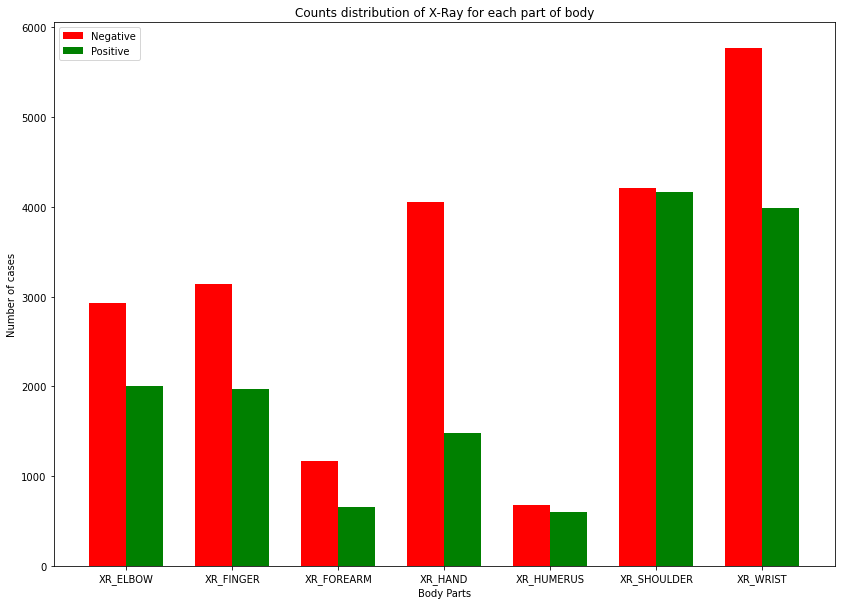

In [16]:
df_train_distr = pd.DataFrame(distr)
df_train_distr['percentage'] = round(100 * df_train_distr['total'] / len(df_train['body_part']), 2)

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = df_train_distr['body_part']
negative = df_train_distr['negative']
positive = df_train_distr['positive']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(14, 10))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative', color='red')
rects2 = ax.bar(x + width/2, positive, width, label='Positive', color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of cases')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray for each part of body')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

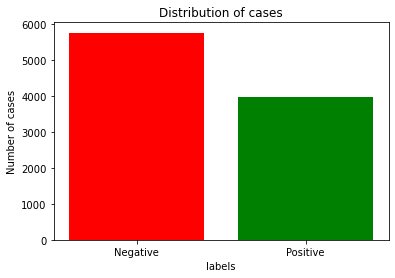

In [17]:
plt.bar(["Negative"], [neg], color='red')
plt.bar(["Positive"], [pos], color='green')

plt.title('Distribution of cases')
plt.xlabel('labels')
plt.ylabel('Number of cases')


plt.show()

In [18]:
X_train = image_loader(df_train['xray_path'], img_size)

 90%|███████████████████████████████████████████████████████████████████▍       | 33113/36812 [02:54<00:26, 137.87it/s]

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|███████████████████████████████████████████████████████████████████████████| 36812/36812 [03:15<00:00, 188.21it/s]


### Test

In [19]:
data = 'data/MURA-v1.1/valid'
dataset = load_data(data)
df_test = pd.DataFrame(dataset)
df_test['patient_id'] = df_test['patient_id'].apply(lambda x: x.replace('patient',''))

In [20]:
body_parts = np.unique(df_test['body_part'])

In [21]:
distr = []
for i in range(len(body_parts)):
    pos, neg, total=calc_distr(df_test[df_test['body_part']==body_parts[i]])
    distr.append(
        {
            'body_part': body_parts[i],
            'positive': pos,
            'negative': neg,
            'total':total
        })

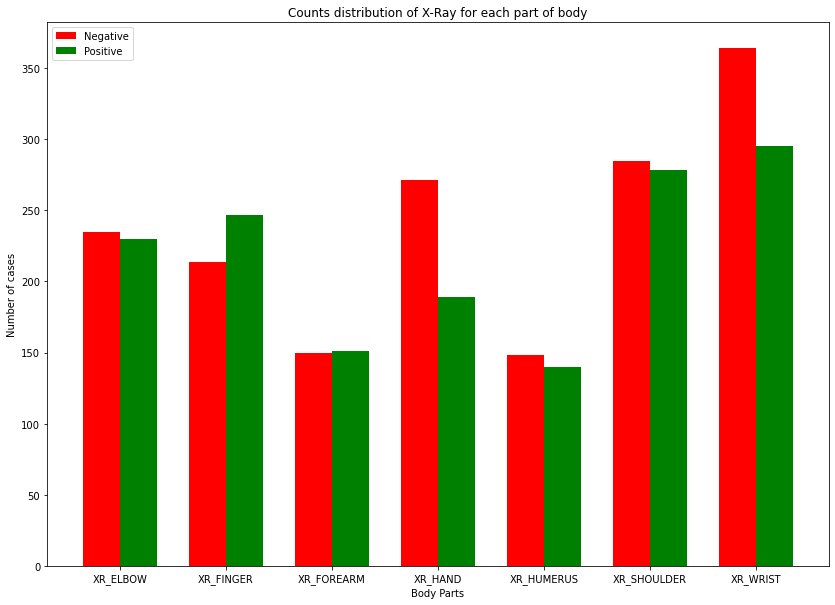

In [22]:
df_test_distr = pd.DataFrame(distr)
df_test_distr['percentage'] = round(100 * df_test_distr['total'] / len(df_test['body_part']), 2)

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = df_test_distr['body_part']
negative = df_test_distr['negative']
positive = df_test_distr['positive']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(14, 10))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative', color='red')
rects2 = ax.bar(x + width/2, positive, width, label='Positive', color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of cases')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray for each part of body')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

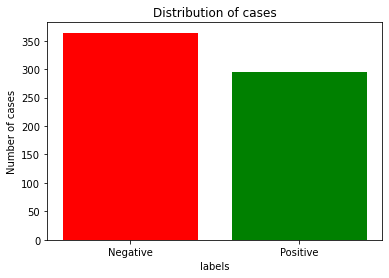

In [23]:
plt.bar(["Negative"], [neg], color='red')
plt.bar(["Positive"], [pos], color='green')

plt.title('Distribution of cases')
plt.xlabel('labels')
plt.ylabel('Number of cases')


plt.show()

### Plots

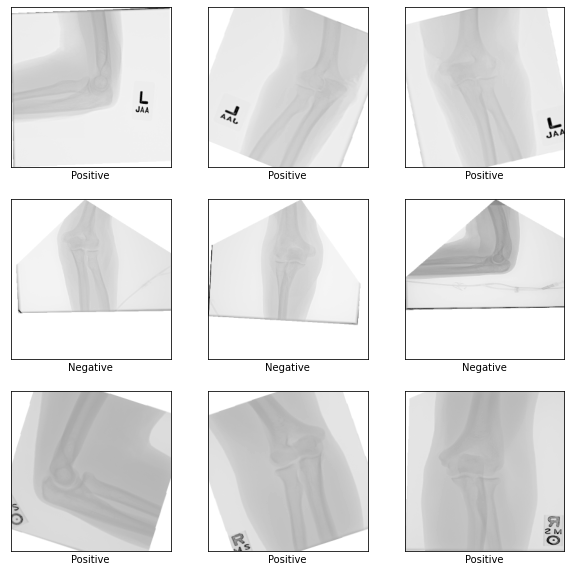

In [24]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])### Plots
    plt.yticks([])
    plot_image(X_train[i], df_train['label'][i])

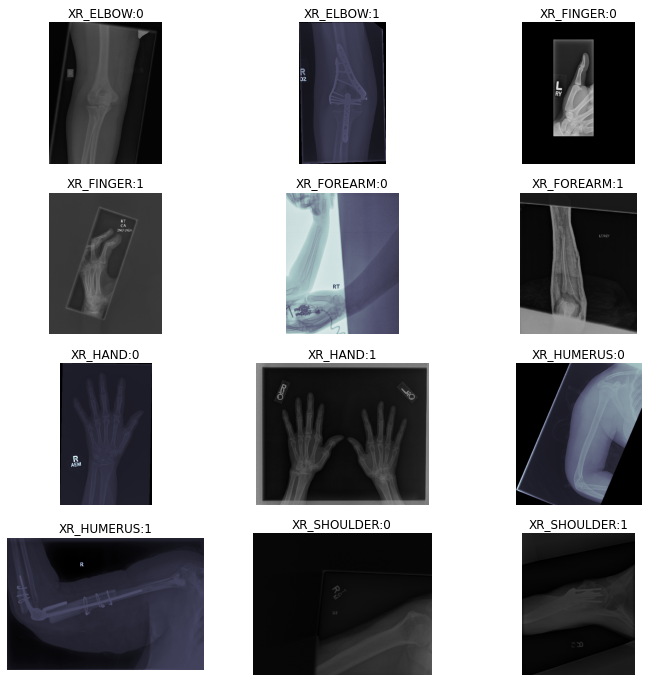

In [25]:
#https://www.kaggle.com/kmader/mura-data-overview
from skimage.io import imread

sub_df = df_train.groupby(['body_part', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['xray_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{body_part}:{label}'.format(**c_row))

fig.savefig('samples.png', dpi = 300)

# Data preparation

In [26]:
train, valid = train_test_split(df_train, 
                               test_size=0.2,
                               random_state=random_seed)
test = df_test.copy()

In [27]:
image_generator_settings = dict(
                          rescale = 1. / 255
                          #samplewise_center = True,
                          #samplewise_std_normalization = True,
                          #rotation_range = 5, 
                         )

image_generator = ImageDataGenerator(**image_generator_settings)

In [28]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=random_seed)

Found 29449 non-validated image filenames.


In [29]:
valid_generator = image_generator.flow_from_dataframe(
    dataframe = valid,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label', #'labels'
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=random_seed)

Found 7363 validated image filenames.


In [30]:
test_generator = image_generator.flow_from_dataframe(
    dataframe = test,
    directory = None,
    x_col = 'xray_path',
    y_col = 'label', #'labels'
    batch_size = 64,
    shuffle = False,
    class_mode = 'raw', #"binary"
    target_size = (img_size, img_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=random_seed)

Found 3197 validated image filenames.


# Models

### Global Callback

In [31]:
epochs = 20

early_stop = EarlyStopping(monitor="kappa",
                           mode="min", 
                           patience=5, 
                           restore_best_weights=True)

## CNN

We will use a `Functional Model` of tensorflow as it is more flexible (not `Sequential`, with add layers)

In [ ]:
def cnn_builder(
        input_shape=(256, 256, 3), # if we want grayscale = 1
        starting_filters=32,
        conv_layers=1,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=False,
        pooling="max",
        dropout=None,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        last_pooling=None,
        spatial_dropout=None,
        last_dropout=None,
):
    
    # Define the input layer.
    inputs = Input(
        shape=input_shape,
        name="input"
    )

    x = inputs

    # Define the convolutional layers.
    for conv_level in range(conv_layers):
        
        current_filters = starting_filters * (2 ** conv_level)
        
        for conv_number in range(convs_per_layer):
            
            x = Conv2D(
                filters=current_filters,
                kernel_size=conv_kernel,
                strides=conv_strides,
                name=f"conv_{conv_level}_{conv_number}",
                padding='same'
            )(x)
            
            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)
            
            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)

        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)

        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size, 
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)

        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)

    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)

    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name="flatten")(x)

    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)

    # Define the output layer.
    output = Dense(1, activation='sigmoid', name="output")(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=output)
    
    return model

## CNN - Baseline

In [ ]:
cnn_model = cnn_builder(starting_filters=32,
                                      conv_layers=4,
                                      convs_per_layer=1,
                                      pooling='max')

cnn_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop])
    
print('Finished training.')
    
print('------------------')
cnn_model.summary() 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 1/100
461/461 [==============================] - 217s 395ms/step - loss: 0.6608 - auc: 0.5909 - accuracy: 0.6020 - kappa: 0.0477 - val_loss: 0.6576 - val_auc: 0.6249 - val_accuracy: 0.6073 - val_kappa: 0.1246
Epoch 2/100
461/461 [==============================] - 178s 385ms/step - loss: 0.6441 - auc: 0.6383 - accuracy: 0.6205 - kappa: 0.1331 - val_loss: 0.6421 - val_auc: 0.6580 - val_accuracy: 0.6197 - val_kappa: 0.1236
Epoch 3/100
461/461 [==============================] - 166s 359ms/step - loss: 0.6206 - auc: 0.6809 - accuracy: 0.6469 - kappa: 0.2180 - val_loss: 0.6265 - val_auc: 0.6966 - val_accuracy: 0.6472 - val_kappa: 0.1970
Epoch 4/100
461/461 [==============================] - 162s 351ms/step - loss: 0.5888 - auc: 0.7267 - accuracy: 0.6840 - kappa: 0.3070 - val_loss: 0.6035 - val_auc: 0.7155 - val_accuracy: 0.6694 - val_kappa: 0.2745
Epoch 5/100
461/461 [==============================] - 162s 352ms/step - loss: 0.5547 - auc: 0.7683 - accuracy: 0.7129 - kappa: 0.3778 - val

In [ ]:
# save model
filename = 'models/cnn_baseline.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_1.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 18s 363ms/step - loss: 0.6322 - auc: 0.7043 - accuracy: 0.6497 - kappa: 0.2908
...Finished clean up...


Train Loss     : 0.09284
Validation Loss: 1.75171
Test Loss      : 0.63218
---
Train AUC     : 0.99450
Validation AUC: 0.69432
Test AUC      : 0.70425
---
Train Accuracy     : 0.96465
Validation Accuracy: 0.65838
Test Accuracy      : 0.64967
---
Train Kappa     : 0.92640
Validation Kappa: 0.92640
Test Kappa      : 0.29082



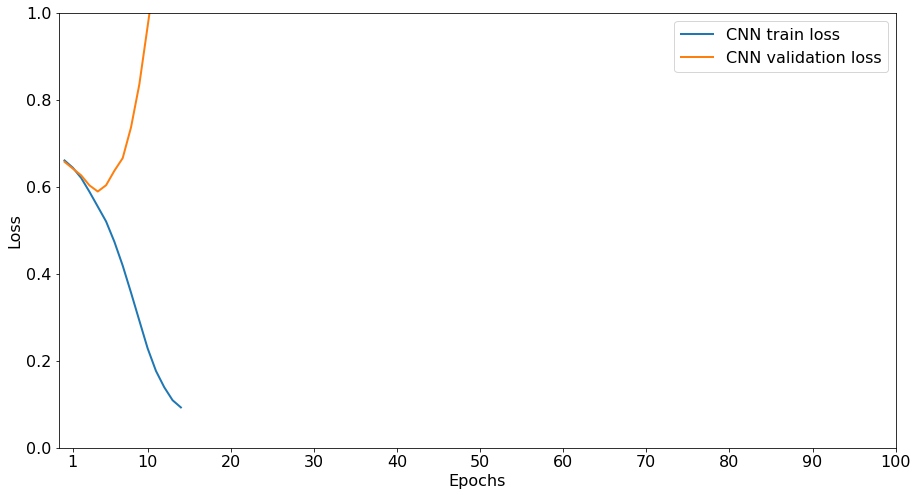

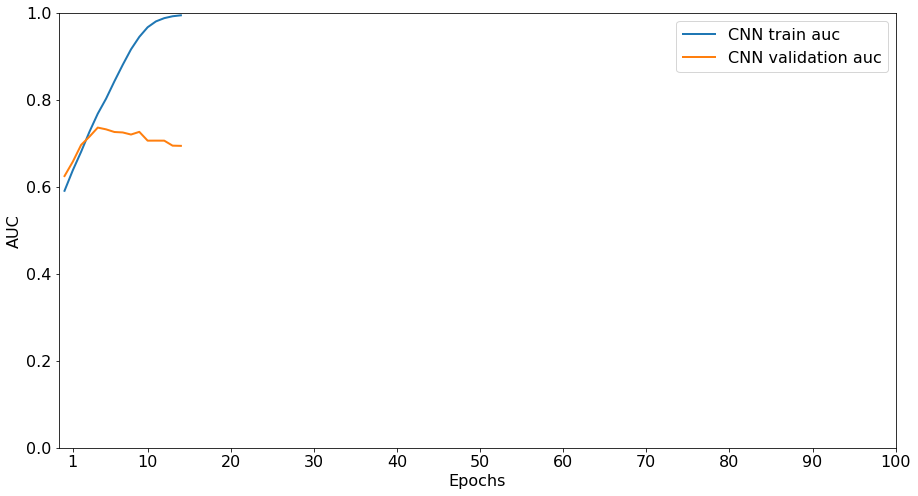

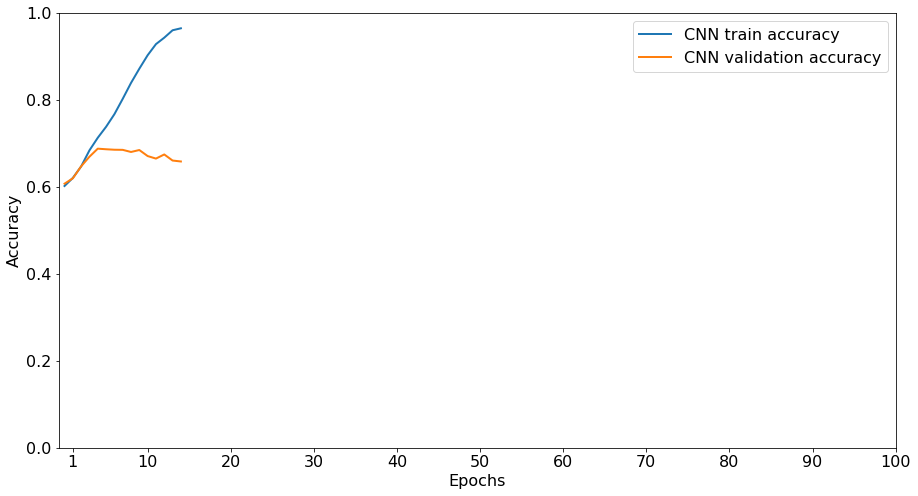

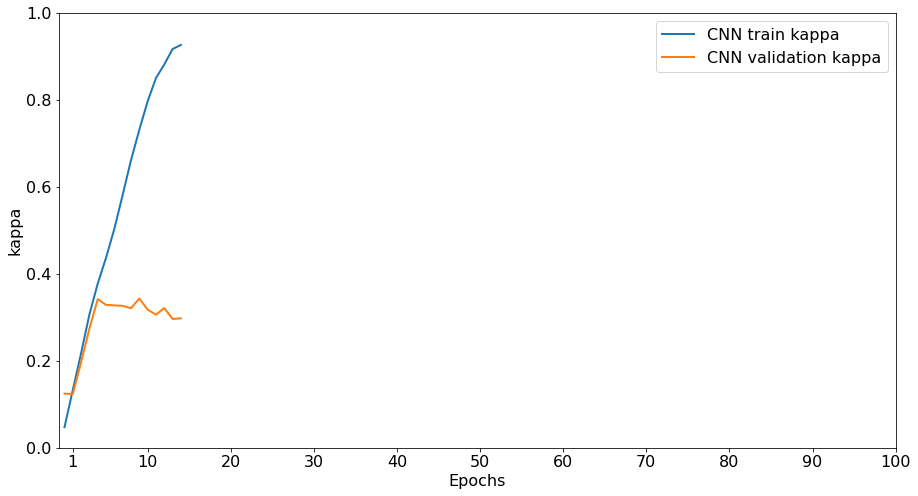

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

## CNN - Complex

In [ ]:
cnn_model = cnn_builder(starting_filters=32,
                                conv_layers=4,
                                convs_per_layer=1,
                                pooling='avg',
                                batch_norm=True,
                                dropout=0.2,
                                pool_strides=(2, 2))

cnn_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop])
    
print('Finished training.')
    
print('------------------')
cnn_model.summary()

Epoch 1/40
461/461 [==============================] - ETA: 0s - loss: 0.9207 - auc: 0.5475 - accuracy: 0.5607 - kappa: 0.0619

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 174s 371ms/step - loss: 0.9207 - auc: 0.5475 - accuracy: 0.5607 - kappa: 0.0619 - val_loss: 0.7540 - val_auc: 0.5854 - val_accuracy: 0.4746 - val_kappa: 0.0590
Epoch 2/40
461/461 [==============================] - 171s 370ms/step - loss: 0.7077 - auc: 0.5865 - accuracy: 0.5924 - kappa: 0.1102 - val_loss: 0.7007 - val_auc: 0.6164 - val_accuracy: 0.6073 - val_kappa: 0.1574
Epoch 3/40
461/461 [==============================] - 171s 372ms/step - loss: 0.6697 - auc: 0.6085 - accuracy: 0.6059 - kappa: 0.1313 - val_loss: 0.7261 - val_auc: 0.6169 - val_accuracy: 0.5875 - val_kappa: 0.0195
Epoch 4/40
461/461 [==============================] - 172s 372ms/step - loss: 0.6501 - auc: 0.6331 - accuracy: 0.6181 - kappa: 0.1484 - val_loss: 0.6723 - val_auc: 0.6264 - val_accuracy: 0.5648 - val_kappa: 0.1593
Epoch 5/40
461/461 [==============================] - 170s 369ms/step - loss: 0.6453 - auc: 0.6402 - accuracy: 0.6248 - kappa: 0.1629 - val_loss: 0.6509 - 

In [ ]:
# save model
filename = 'models/cnn_complex.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_3.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 15s 300ms/step - loss: 0.6342 - auc: 0.7167 - accuracy: 0.6581 - kappa: 0.3077
...Finished clean up...


Train Loss     : 0.44815
Validation Loss: 0.85330
Test Loss      : 0.63419
---
Train AUC     : 0.86130
Validation AUC: 0.65808
Test AUC      : 0.71669
---
Train Accuracy     : 0.78839
Validation Accuracy: 0.63923
Test Accuracy      : 0.65812
---
Train Kappa     : 0.55070
Validation Kappa: 0.55070
Test Kappa      : 0.30771



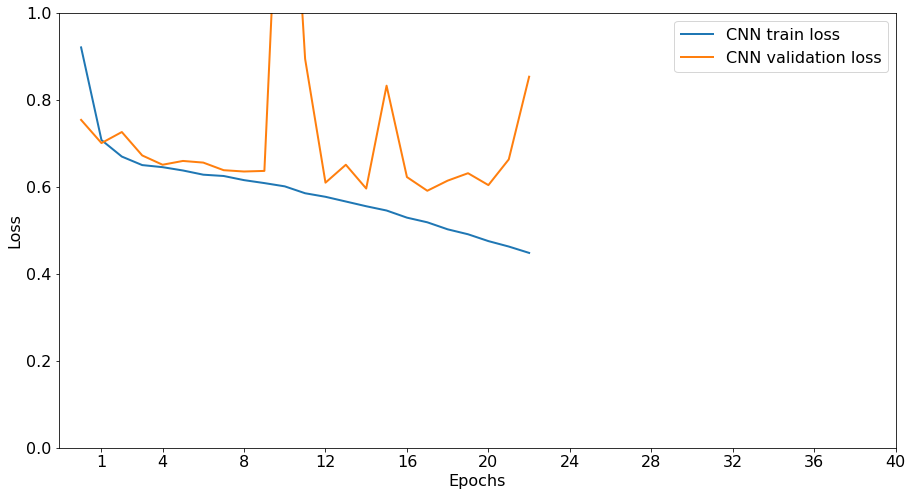

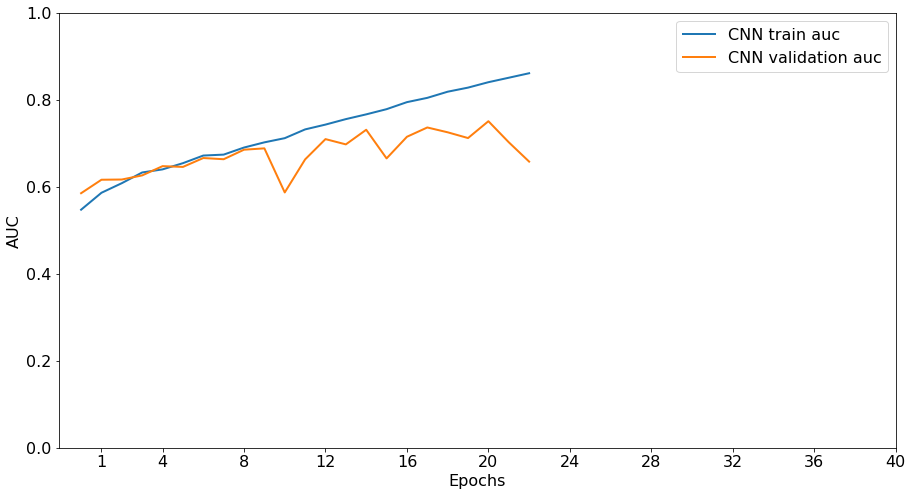

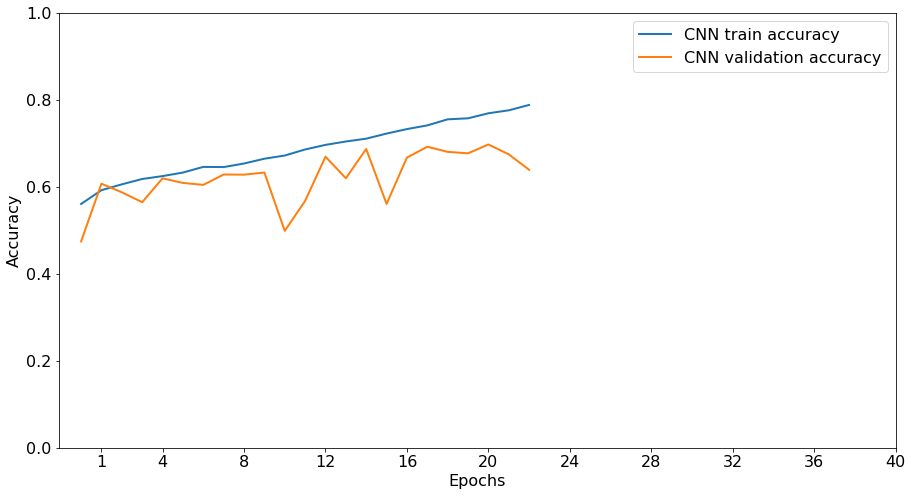

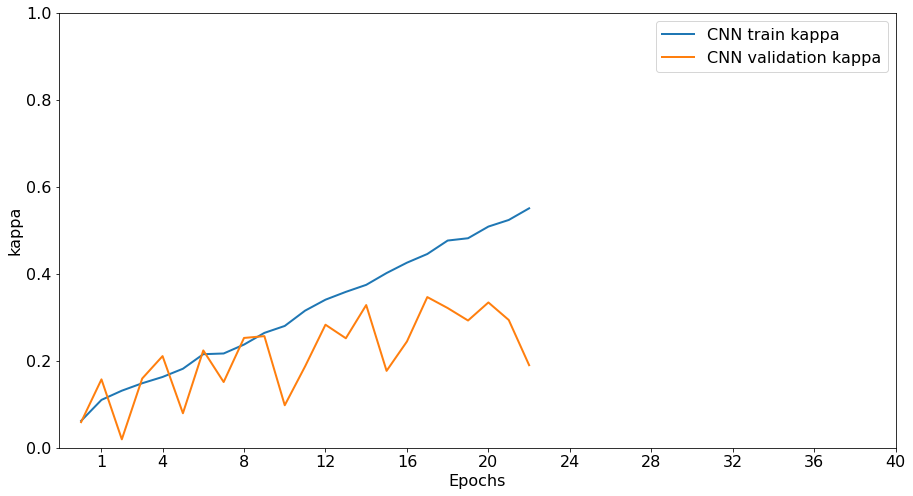

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

## ResNet

In [ ]:
def resnet_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):

    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )

    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False

    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )

    return model

In [ ]:
resnet_model = resnet_builder(pooling='avg')

resnet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

hs = resnet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
resnet_model.summary()

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/10
461/461 [==============================] - ETA: 0s - loss: 0.5793 - auc: 0.7422 - accuracy: 0.7014 - kappa: 0.3550

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 352s 679ms/step - loss: 0.5793 - auc: 0.7422 - accuracy: 0.7014 - kappa: 0.3550 - val_loss: 0.5463 - val_auc: 0.7867 - val_accuracy: 0.7264 - val_kappa: 0.4272
Epoch 2/10
461/461 [==============================] - 320s 693ms/step - loss: 0.5334 - auc: 0.7920 - accuracy: 0.7398 - kappa: 0.4409 - val_loss: 0.5694 - val_auc: 0.7996 - val_accuracy: 0.7202 - val_kappa: 0.3721
Epoch 3/10
461/461 [==============================] - 320s 694ms/step - loss: 0.5213 - auc: 0.8024 - accuracy: 0.7483 - kappa: 0.4597 - val_loss: 0.5264 - val_auc: 0.8058 - val_accuracy: 0.7502 - val_kappa: 0.4660
Epoch 4/10
461/461 [==============================] - 319s 693ms/step - loss: 0.5126 - auc: 0.8106 - accuracy: 0.7551 - kappa: 0.4747 - val_loss: 0.5519 - val_auc: 0.8082 - val_accuracy: 0.7325 - val_kappa: 0.4060
Finished training.
------------------
Model: "resnet"
_________________________________________________________________
Layer (type)                 Output

In [ ]:
# save model
filename = 'models/resnet.h5'
resnet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
resnet_model_eval = resnet_model.evaluate(test_generator)
clean_up(model=resnet_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved models/model_5.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 30s 589ms/step - loss: 0.5535 - auc: 0.7883 - accuracy: 0.7210 - kappa: 0.4367
...Finished clean up...


Train Loss     : 0.51262
Validation Loss: 0.55185
Test Loss      : 0.55354
---
Train AUC     : 0.81060
Validation AUC: 0.80821
Test AUC      : 0.78835
---
Train Accuracy     : 0.75511
Validation Accuracy: 0.73255
Test Accuracy      : 0.72099
---
Train Kappa     : 0.47469
Validation Kappa: 0.47469
Test Kappa      : 0.43671



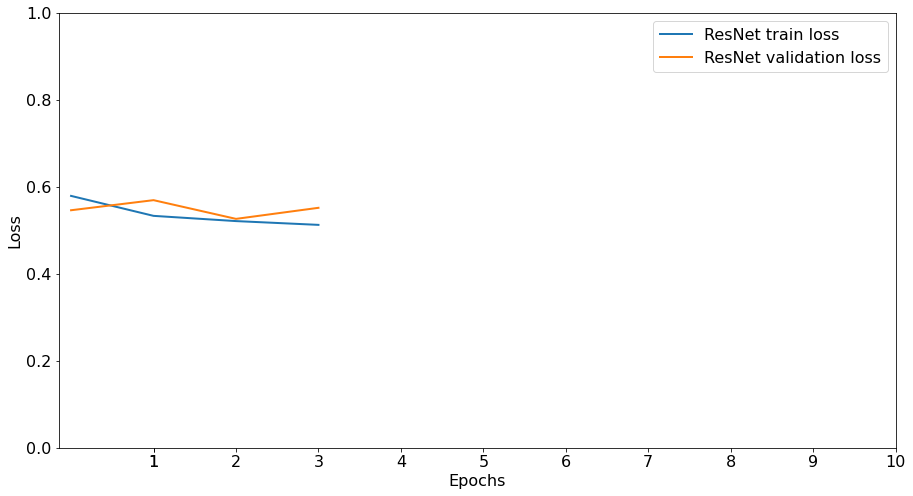

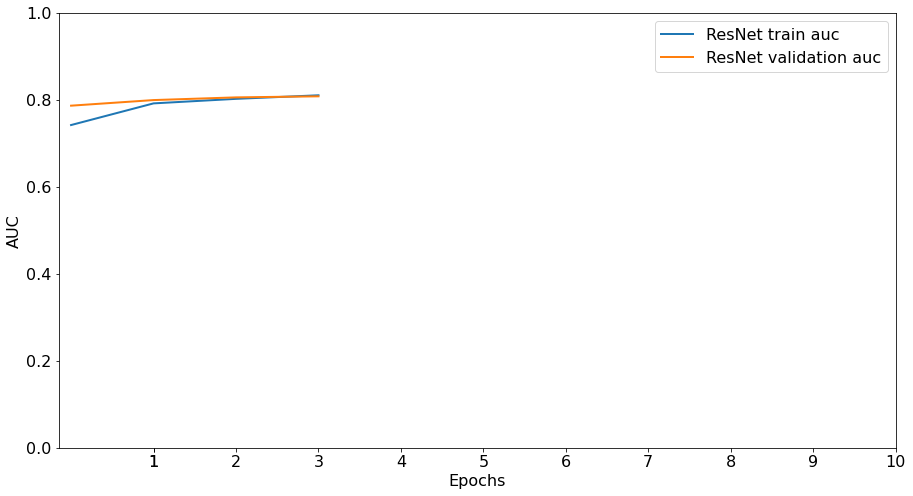

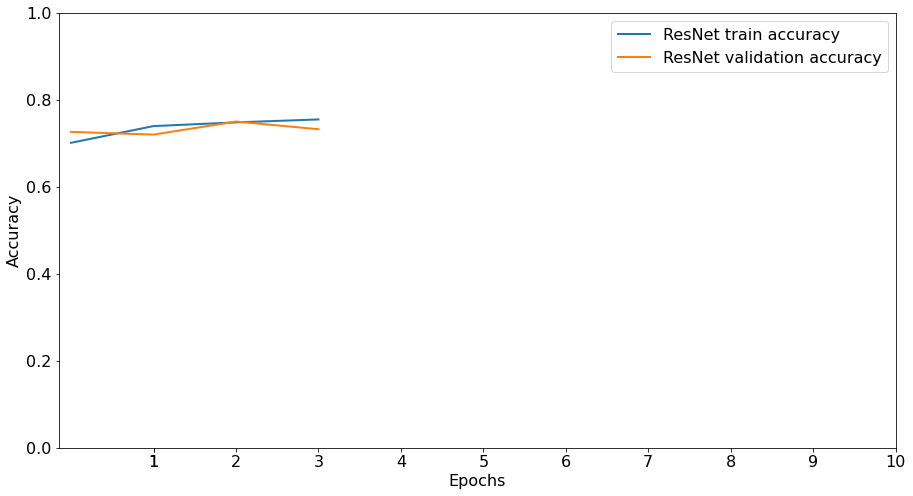

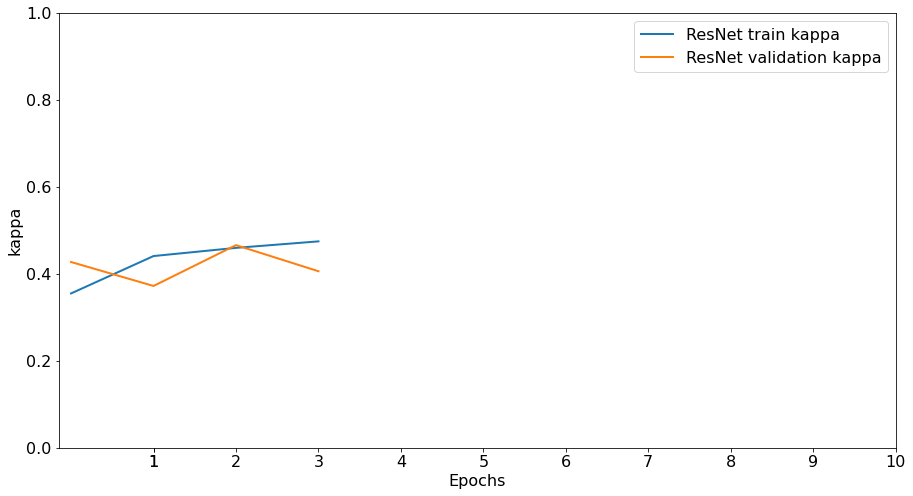

In [ ]:
print_results(model_name='ResNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = resnet_model_eval)